In [67]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras.layers import AveragePooling2D, MaxPooling2D, Convolution2D, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Activation, Concatenate
from keras import Sequential

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19


In [68]:
main_directory = 'apple_jpeg_images'
split_directory = 'split'

os.makedirs(split_directory, exist_ok=True)
class_directories = [f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))]

In [69]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [70]:
train_directory = os.path.join(split_directory, 'train')
validation_directory = os.path.join(split_directory, 'validation')
test_directory = os.path.join(split_directory, 'test')

os.makedirs(train_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Iterate through each class directory and move images to the appropriate split
for class_dir in class_directories:
    class_path = os.path.join(main_directory, class_dir)
    files = os.listdir(class_path)
    num_samples = len(files)
    
    num_train = int(train_ratio * num_samples)
    num_validation = int(validation_ratio * num_samples)
    
    train_samples = files[:num_train]
    validation_samples = files[num_train:num_train + num_validation]
    test_samples = files[num_train + num_validation:]
    
    for file in train_samples:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_directory, class_dir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)
    
    for file in validation_samples:
        src = os.path.join(class_path, file)
        dst = os.path.join(validation_directory, class_dir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)
    
 
    for file in test_samples:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_directory, class_dir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)


In [71]:
input_shape = (256, 256, 3)
batch_size = 32

In [72]:
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_directory(
    train_directory,  
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False  # Set to False to maintain class-wise order
)

# Get the class labels and their corresponding indices
class_indices = generator.class_indices
num_classes = len(class_indices.items())

for class_name, class_idx in class_indices.items():
    class_count = (generator.classes == class_idx).sum()
    print(f'Class {class_name}: {class_count} samples')


Found 2380 images belonging to 4 classes.
Class healthy: 595 samples
Class powdery_mildew: 595 samples
Class rust: 595 samples
Class scab: 595 samples


Class healthy: 595 samples


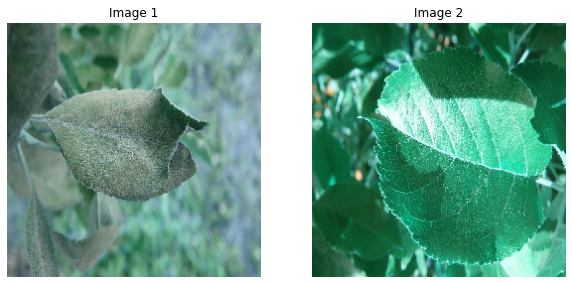

Class powdery_mildew: 595 samples


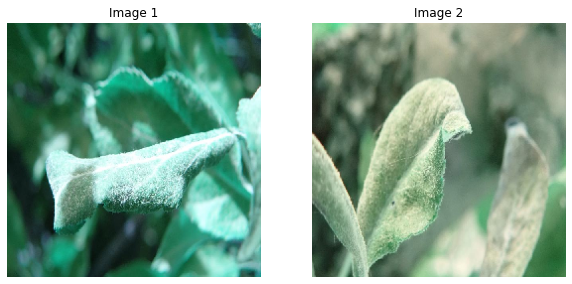

Class rust: 595 samples


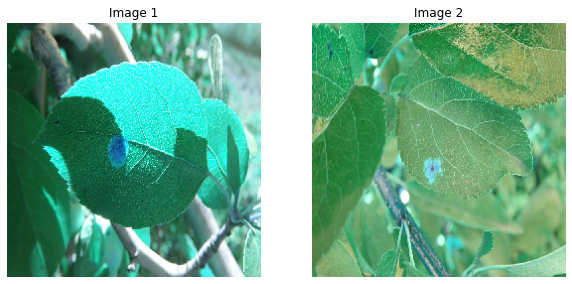

Class scab: 595 samples


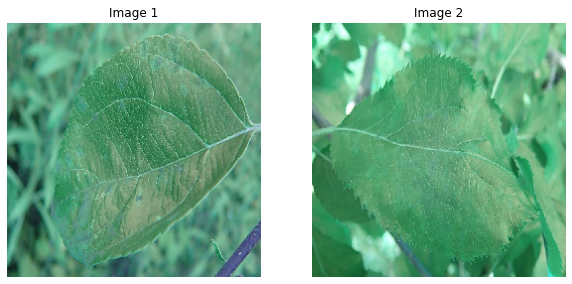

In [73]:
num_images_per_class = 2  

for class_name, class_idx in class_indices.items():
    class_count = (generator.classes == class_idx).sum()
    
    if class_count > 0:
        print(f'Class {class_name}: {class_count} samples')
        plt.figure(figsize=(10, 5))
        
        # Retrieve the first num_images_per_class images from the generator
        images_to_display = []
        for i, (image, label) in enumerate(generator):
            if label[0, class_idx] == 1:
                images_to_display.append(image[0])
            if len(images_to_display) >= num_images_per_class:
                break
        
        for i, img in enumerate(images_to_display):
            plt.subplot(1, num_images_per_class, i + 1)
            plt.imshow(img)
            plt.title(f'Image {i + 1}')
            plt.axis('off')
        
        plt.show()

In [74]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to [0, 1]
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators for train, validation, and test
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2380 images belonging to 4 classes.
Found 508 images belonging to 4 classes.
Found 512 images belonging to 4 classes.


In [75]:
epochs = 50
learning_rate=0.0001

adam = Adam(lr=learning_rate)

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5) #change learning rATE  to get the best result

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [76]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = input_shape)
#base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (img_width,img_height,3)) #
#base_model = ResNet101(include_top = False, weights = 'imagenet', input_shape = (img_width,img_height,3))
#base_model = Xception(include_top = False, weights = 'imagenet', input_shape = (img_width,img_height, 3))
#base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (img_width,img_height,3))
#base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (img_width,img_height,3))


#use resnet - try various versions of resnet
#compare googlenet to resnet and the other 4, to see which one is better. use the latest version of them

#changing the last layer
for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[model_checkpoint, early_stopping, lrr]
)

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.5043 - accuracy: 0.3130
Epoch 1: val_loss improved from inf to 1.23787, saving model to best_model.h5
74/74 [==============================] - 98s 1s/step - loss: 1.5043 - accuracy: 0.3130 - val_loss: 1.2379 - val_accuracy: 0.4396 - lr: 1.0000e-04
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.3768 - accuracy: 0.3765
Epoch 2: val_loss improved from 1.23787 to 1.10385, saving model to best_model.h5
74/74 [==============================] - 92s 1s/step - loss: 1.3768 - accuracy: 0.3765 - val_loss: 1.1039 - val_accuracy: 0.5542 - lr: 1.0000e-04
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 1.2737 - accuracy: 0.4242
Epoch 3: val_loss improved from 1.10385 to 1.01648, saving model to best_model.h5
74/74 [==============================] - 93s 1s/step - loss: 1.2737 - accuracy: 0.4242 - val_loss: 1.0165 - val_accuracy: 0.6313 - lr: 1.0000e-04
Epoch 4/50
74/74 [====================

In [78]:
from tensorflow import keras

loaded_model = keras.models.load_model('best_model.h5')

In [79]:
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 [==============================] - 16s 869ms/step - loss: 0.6693 - accuracy: 0.7461
Test Loss: 0.6693
Test Accuracy: 74.61%


In [80]:
y_pred = loaded_model.predict(test_generator)
y_true = test_generator.classes

# Generate a classification report
target_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(y_true, y_pred.argmax(axis=1), target_names=target_names)
print("Classification Report:\n", classification_rep)

Classification Report:
                 precision    recall  f1-score   support

       healthy       0.61      0.80      0.69       128
powdery_mildew       0.89      0.85      0.87       128
          rust       0.80      0.78      0.79       128
          scab       0.74      0.55      0.63       128

      accuracy                           0.75       512
     macro avg       0.76      0.75      0.75       512
  weighted avg       0.76      0.75      0.75       512



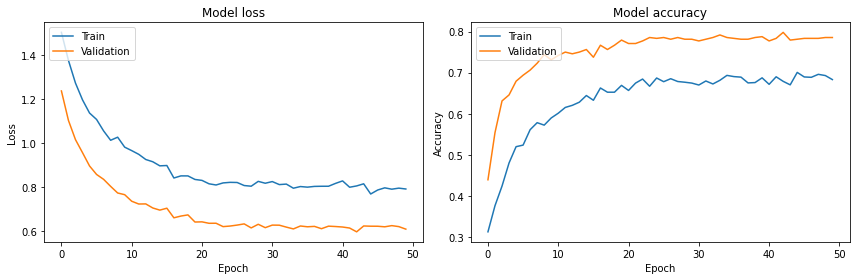

In [81]:
# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [82]:
f1_macro = f1_score(y_true, y_pred.argmax(axis=1), average='macro')
f1_weighted = f1_score(y_true, y_pred.argmax(axis=1), average='weighted')

print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")

Weighted F1 Score: 0.7451
Macro F1 Score: 0.7451
